In [27]:
import xclim
import xarray as xr
import cftime
import xclim.sdba as sdba
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import os

from xclim.sdba.base import Grouper

In [29]:
lat_min, lat_max = 5.0, 5.5
lon_min, lon_max = -5.6, -4.5

In [31]:
observations = xr.open_dataset('O:\\Public\\sharing-4270-CERM\\MATNEW\\Era5-Land\\Hourly_Data\\Precipitation\\era5_land_1950_2024_tp_daily_update_DK_regridCLIMEX.nc')
observations = observations.rename({"tp": "pr"})
observations = observations *1000
observations = observations.sel(rlat=slice(lat_min, lat_max), rlon=slice(lon_min, lon_max))

In [32]:
#Select period for calibration in observational time series
obs_calib = observations['pr'].sel(time=slice("1981-01-01", "2010-12-31"))

In [33]:
#Create mask to match pixels between datasets
mask = xr.where(observations.sel(time='1981-01-01').notnull(), 1, 0)

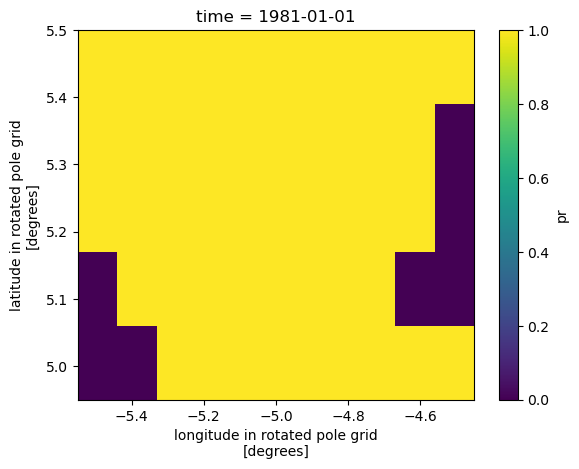

In [37]:
mask.pr.plot()

In [39]:
# Ensembles of CLIMEX1
string = 'kbi  kbh  kbg  kbf  kbe  kbd  kbc  kbb  kba  kcx  kcw  kcv  kcu  kct  kcs  kcr  kcq  kcp  kco  kcn  kcm  kcl  kck  kcj  kci  kch  kcg  kcf  kce  kcd  kcc  kcb  kca  kbz  kby  kbx  kbw  kbv  kbu  kbt  kbs  kbr  kbq  kbp  kbo  kbn  kbm  kbl  kbk  kbj  '
ensembles = string.split( )
ensembles.sort()

In [41]:
# Paths
input_path = "O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\"
output_path = "O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily_bc_V2\\"

In [43]:
%%time
for i, ens in enumerate(ensembles):
    print(ens)
    
    file = glob.glob(input_path + ens + "/pr_*")
    
    print(file)
    
    #Grab ensemble member
    model_daily = xr.open_dataset(file[0])
    model_daily = model_daily.sel(rlat=slice(lat_min, lat_max), rlon=slice(lon_min, lon_max))
    
    #Mask the model data
    mask_expanded_model = mask.expand_dims(time=model_daily.time)
    model_daily = model_daily.where(mask_expanded_model)
    model_daily = model_daily +1 #Add constant to avoid infinity error
    obs_calib_adj = obs_calib +1 #Add constant to avoid infinity error
    
    #Select the calibration periods and period to apply bias correction
    model_calib = model_daily.sel(time=slice("1981-01-01", "2010-12-31"))['pr']
    model_bc = model_daily['pr']
    #model_daily.min()
    
    #Set the units 
    model_calib.attrs['units'] = 'mm/day'
    obs_calib_adj.attrs['units'] = 'mm/day'
    model_bc.attrs['units'] = 'mm/day'
    
    #Apply QDM bias correction 
    qdm = sdba.QuantileDeltaMapping.train(ref=obs_calib_adj, hist=model_calib, group=Grouper("time.month"), kind = '*')
    corrected_qdm = qdm.adjust(model_bc)
    
    corrected_qdm = corrected_qdm -1 
    obs_calib_adj = obs_calib_adj -1 
    model_calib = model_calib -1
    model_bc = model_bc -1 
    
    #Fix if negative values appear
    corrected_qdm.values[corrected_qdm.values <= 0.0] = 0.0
    
    corrected_qdm.attrs['units'] = 'mm/day'
    model_calib.attrs['units'] = 'mm/day'
    obs_calib_adj.attrs['units'] = 'mm/day'
    model_bc.attrs['units'] = 'mm/day'
    
    # Apply EVT (GPD) to the tails (extremes) of data
    #extremes = sdba.ExtremeValues.train(ref=obs_calib_adj, hist=model_calib, q_thresh=0.98, cluster_thresh = "6.5 mm/day")
    #corrected_with_extremes = extremes.adjust(sim = model_bc, scen = corrected_qdm)
    
    #Remove drizzle effect in RCM outputs 
    #corrected_with_extremes.values[corrected_with_extremes.values <= 0.5] = 0
    
    #Transpose the datarray (fix issue with BC method switching position of latitude and longitude)
    corrected_qdm = corrected_qdm.transpose("time", "rlat", "rlon")
    
    #Rename variable from 'scen' to 'pr'
    corrected_qdm = corrected_qdm.rename("pr")
    
    #Create output directory
    output_dir = f"{output_path}{ens}"
    
    #Create folder path in directroy
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    #Grab model name string
    match = re.search(r'pr_EUR.*?-CRCM5', file[0])
    
    name = match.group(0)
    
    #Save final output name
    output_path_model = os.path.join(output_dir, f"{name}_{ens}_day_1951-2100_BC_Esbjerg.nc")
    
    #Export NetCDF
    corrected_qdm.to_dataset().to_netcdf(output_path_model)

kba
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kba\\pr_EUR-11_CCCma-CanESM2_historical_r1-r1i1p1_OURANOS-CRCM5_kba_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbb
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbb\\pr_EUR-11_CCCma-CanESM2_historical_r1-r2i1p1_OURANOS-CRCM5_kbb_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbc
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbc\\pr_EUR-11_CCCma-CanESM2_historical_r1-r3i1p1_OURANOS-CRCM5_kbc_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbd
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbd\\pr_EUR-11_CCCma-CanESM2_historical_r1-r4i1p1_OURANOS-CRCM5_kbd_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbe
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbe\\pr_EUR-11_CCCma-CanESM2_historical_r1-r5i1p1_OURANOS-CRCM5_kbe_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbf
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbf\\pr_EUR-11_CCCma-CanESM2_historical_r1-r6i1p1_OURANOS-CRCM5_kbf_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbg
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbg\\pr_EUR-11_CCCma-CanESM2_historical_r1-r7i1p1_OURANOS-CRCM5_kbg_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbh
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbh\\pr_EUR-11_CCCma-CanESM2_historical_r1-r8i1p1_OURANOS-CRCM5_kbh_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbi
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbi\\pr_EUR-11_CCCma-CanESM2_historical_r1-r9i1p1_OURANOS-CRCM5_kbi_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbj
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbj\\pr_EUR-11_CCCma-CanESM2_historical_r1-r10i1p1_OURANOS-CRCM5_kbj_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbk
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbk\\pr_EUR-11_CCCma-CanESM2_historical_r2-r1i1p1_OURANOS-CRCM5_kbk_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbl
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbl\\pr_EUR-11_CCCma-CanESM2_historical_r2-r2i1p1_OURANOS-CRCM5_kbl_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbm
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbm\\pr_EUR-11_CCCma-CanESM2_historical_r2-r3i1p1_OURANOS-CRCM5_kbm_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbn
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbn\\pr_EUR-11_CCCma-CanESM2_historical_r2-r4i1p1_OURANOS-CRCM5_kbn_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbo
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbo\\pr_EUR-11_CCCma-CanESM2_historical_r2-r5i1p1_OURANOS-CRCM5_kbo_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbp
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbp\\pr_EUR-11_CCCma-CanESM2_historical_r2-r6i1p1_OURANOS-CRCM5_kbp_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbq
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbq\\pr_EUR-11_CCCma-CanESM2_historical_r2-r7i1p1_OURANOS-CRCM5_kbq_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbr
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbr\\pr_EUR-11_CCCma-CanESM2_historical_r2-r8i1p1_OURANOS-CRCM5_kbr_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbs
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbs\\pr_EUR-11_CCCma-CanESM2_historical_r2-r9i1p1_OURANOS-CRCM5_kbs_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbt
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbt\\pr_EUR-11_CCCma-CanESM2_historical_r2-r10i1p1_OURANOS-CRCM5_kbt_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbu
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbu\\pr_EUR-11_CCCma-CanESM2_historical_r3-r1i1p1_OURANOS-CRCM5_kbu_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbv
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbv\\pr_EUR-11_CCCma-CanESM2_historical_r3-r2i1p1_OURANOS-CRCM5_kbv_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbw
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbw\\pr_EUR-11_CCCma-CanESM2_historical_r3-r3i1p1_OURANOS-CRCM5_kbw_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbx
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbx\\pr_EUR-11_CCCma-CanESM2_historical_r3-r4i1p1_OURANOS-CRCM5_kbx_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kby
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kby\\pr_EUR-11_CCCma-CanESM2_historical_r3-r5i1p1_OURANOS-CRCM5_kby_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kbz
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kbz\\pr_EUR-11_CCCma-CanESM2_historical_r3-r6i1p1_OURANOS-CRCM5_kbz_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kca
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kca\\pr_EUR-11_CCCma-CanESM2_historical_r3-r7i1p1_OURANOS-CRCM5_kca_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcb
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcb\\pr_EUR-11_CCCma-CanESM2_historical_r3-r8i1p1_OURANOS-CRCM5_kcb_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcc
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcc\\pr_EUR-11_CCCma-CanESM2_historical_r3-r9i1p1_OURANOS-CRCM5_kcc_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcd
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcd\\pr_EUR-11_CCCma-CanESM2_historical_r3-r10i1p1_OURANOS-CRCM5_kcd_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kce
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kce\\pr_EUR-11_CCCma-CanESM2_historical_r4-r1i1p1_OURANOS-CRCM5_kce_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcf
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcf\\pr_EUR-11_CCCma-CanESM2_historical_r4-r2i1p1_OURANOS-CRCM5_kcf_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcg
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcg\\pr_EUR-11_CCCma-CanESM2_historical_r4-r3i1p1_OURANOS-CRCM5_kcg_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kch
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kch\\pr_EUR-11_CCCma-CanESM2_historical_r4-r4i1p1_OURANOS-CRCM5_kch_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kci
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kci\\pr_EUR-11_CCCma-CanESM2_historical_r4-r5i1p1_OURANOS-CRCM5_kci_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcj
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcj\\pr_EUR-11_CCCma-CanESM2_historical_r4-r6i1p1_OURANOS-CRCM5_kcj_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kck
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kck\\pr_EUR-11_CCCma-CanESM2_historical_r4-r7i1p1_OURANOS-CRCM5_kck_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcl
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcl\\pr_EUR-11_CCCma-CanESM2_historical_r4-r8i1p1_OURANOS-CRCM5_kcl_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcm
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcm\\pr_EUR-11_CCCma-CanESM2_historical_r4-r9i1p1_OURANOS-CRCM5_kcm_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcn
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcn\\pr_EUR-11_CCCma-CanESM2_historical_r4-r10i1p1_OURANOS-CRCM5_kcn_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kco
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kco\\pr_EUR-11_CCCma-CanESM2_historical_r5-r1i1p1_OURANOS-CRCM5_kco_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcp
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcp\\pr_EUR-11_CCCma-CanESM2_historical_r5-r2i1p1_OURANOS-CRCM5_kcp_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcq
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcq\\pr_EUR-11_CCCma-CanESM2_historical_r5-r3i1p1_OURANOS-CRCM5_kcq_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcr
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcr\\pr_EUR-11_CCCma-CanESM2_historical_r5-r4i1p1_OURANOS-CRCM5_kcr_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcs
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcs\\pr_EUR-11_CCCma-CanESM2_historical_r5-r5i1p1_OURANOS-CRCM5_kcs_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kct
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kct\\pr_EUR-11_CCCma-CanESM2_historical_r5-r6i1p1_OURANOS-CRCM5_kct_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcu
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcu\\pr_EUR-11_CCCma-CanESM2_historical_r5-r7i1p1_OURANOS-CRCM5_kcu_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcv
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcv\\pr_EUR-11_CCCma-CanESM2_historical_r5-r8i1p1_OURANOS-CRCM5_kcv_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcw
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcw\\pr_EUR-11_CCCma-CanESM2_historical_r5-r9i1p1_OURANOS-CRCM5_kcw_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


kcx
['O:\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_daily\\kcx\\pr_EUR-11_CCCma-CanESM2_historical_r5-r10i1p1_OURANOS-CRCM5_kcx_day_1955_2100.nc']


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


CPU times: total: 2min 52s
Wall time: 32min 54s


In [21]:
name

'pr_daily\\kba\\pr_EUR-11_CCCma-CanESM2_historical_r1-r1i1p1_OURANOS-CRCM5'

In [21]:
corrected_with_extremes = corrected_qdm.sel(time=slice("1981-01-01", "2010-12-31"))

In [23]:
corrected_with_extremes.max()

<xarray.DataArray 'pr' ()> Size: 8B
array(67.18643188)

In [25]:
obs_calib.max()

<xarray.DataArray 'pr' ()> Size: 8B
array(57.52758408)

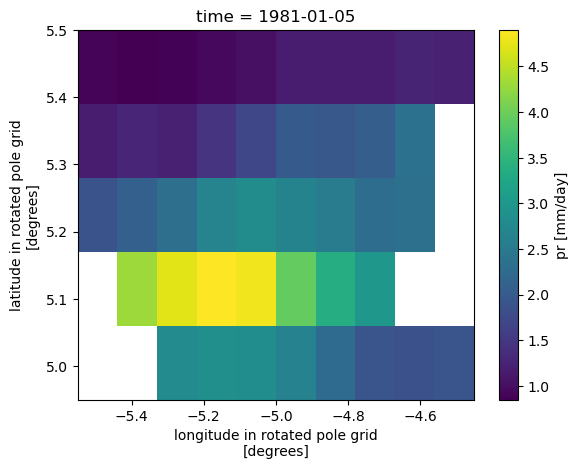

In [27]:
corrected_with_extremes.sel(time = '1981-01-05').plot()

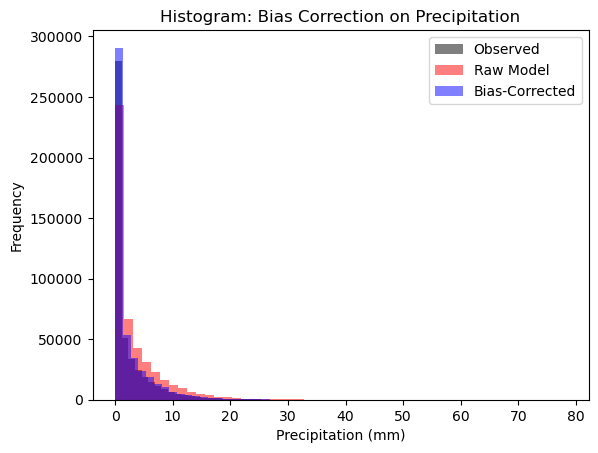

In [29]:
plt.hist(obs_calib_adj.values.flatten(), bins=50, alpha=0.5, label="Observed", color="black")
plt.hist(model_calib.values.flatten(), bins=50, alpha=0.5, label="Raw Model", color="red")
plt.hist(corrected_with_extremes.values.flatten(), bins=50, alpha=0.5, label="Bias-Corrected", color="blue")


plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Histogram: Bias Correction on Precipitation")
plt.show()


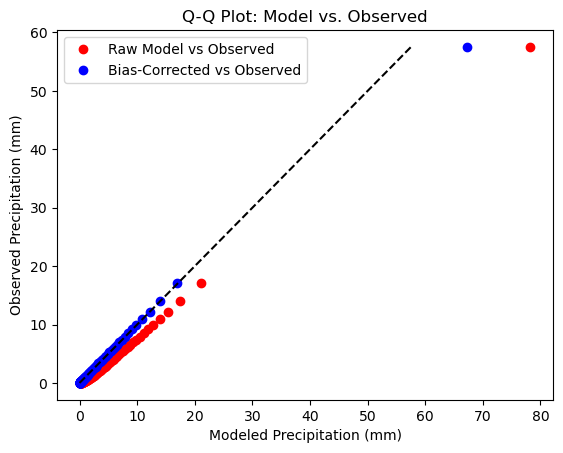

In [31]:
import scipy.stats as stats
import numpy as np

# Flatten DataArrays to 1D NumPy arrays
model_q = np.nanquantile(model_calib.values.flatten(), np.linspace(0, 1, 100))
corrected_q = np.nanquantile(corrected_with_extremes.values.flatten(), np.linspace(0, 1, 100))
obs_q = np.nanquantile(obs_calib_adj.values.flatten(), np.linspace(0, 1, 100))

# Plot Q-Q comparison
plt.plot(model_q, obs_q, "ro", label="Raw Model vs Observed")
plt.plot(corrected_q, obs_q, "bo", label="Bias-Corrected vs Observed")
plt.plot([min(obs_q), max(obs_q)], [min(obs_q), max(obs_q)], "k--")  # 1:1 line

plt.xlabel("Modeled Precipitation (mm)")
plt.ylabel("Observed Precipitation (mm)")
plt.legend()
plt.title("Q-Q Plot: Model vs. Observed"),
plt.show()

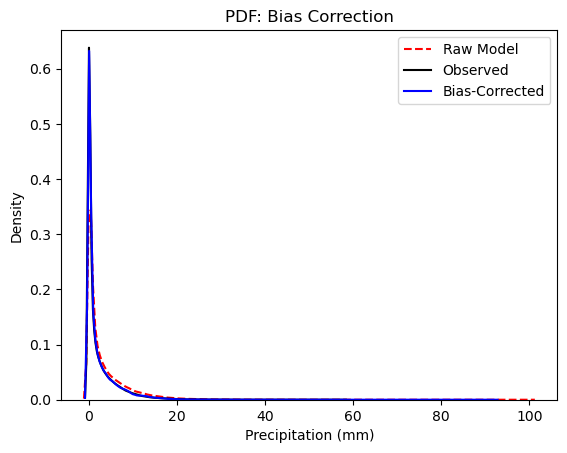

In [99]:
import seaborn as sns

sns.kdeplot(model_calib.values.flatten(), label="Raw Model", color="red", linestyle ="dashed")
sns.kdeplot(obs_calib_adj.values.flatten(), label="Observed", color="black")
sns.kdeplot(corrected_with_extremes.values.flatten(), label="Bias-Corrected", color="blue")

plt.xlabel("Precipitation (mm)")
plt.ylabel("Density")
plt.legend()
plt.title("PDF: Bias Correction")
plt.show()

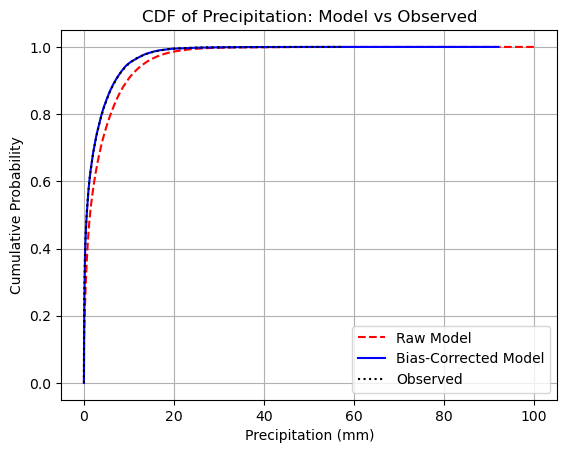

In [100]:
# Flatten DataArrays to 1D NumPy arrays (removing NaNs)
model_values = model_calib.values.flatten()
corrected_values = corrected_with_extremes.values.flatten()
obs_values = obs_calib_adj.values.flatten()

# Remove NaNs (if any)
model_values = model_values[~np.isnan(model_values)]
corrected_values = corrected_values[~np.isnan(corrected_values)]
obs_values = obs_values[~np.isnan(obs_values)]

# Compute CDFs
sorted_model = np.sort(model_values)
sorted_corrected = np.sort(corrected_values)
sorted_obs = np.sort(obs_values)

cdf_model = np.linspace(0, 1, len(sorted_model))
cdf_corrected = np.linspace(0, 1, len(sorted_corrected))
cdf_obs = np.linspace(0, 1, len(sorted_obs))

# Plot CDFs
plt.plot(sorted_model, cdf_model, label="Raw Model", linestyle="dashed", color="red")
plt.plot(sorted_corrected, cdf_corrected, label="Bias-Corrected Model", linestyle="solid", color="blue")
plt.plot(sorted_obs, cdf_obs, label="Observed", linestyle="dotted", color="black")

# Labels and legend
plt.xlabel("Precipitation (mm)")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Precipitation: Model vs Observed")
plt.legend()
plt.grid()